# Pistachio Image Classification - PyTorch - Transfer Learning

## 1. Introduction

In [75]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors, models
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as T
from sklearn.model_selection import train_test_split

In [2]:
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121


Load environment configuration

In [3]:
with open("configuration.json", "r") as f:
    data_configuration = json.load(f)

Mount data source

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH_DATA = data_configuration["path_data"]

## 2. EDA

Explore images per classes

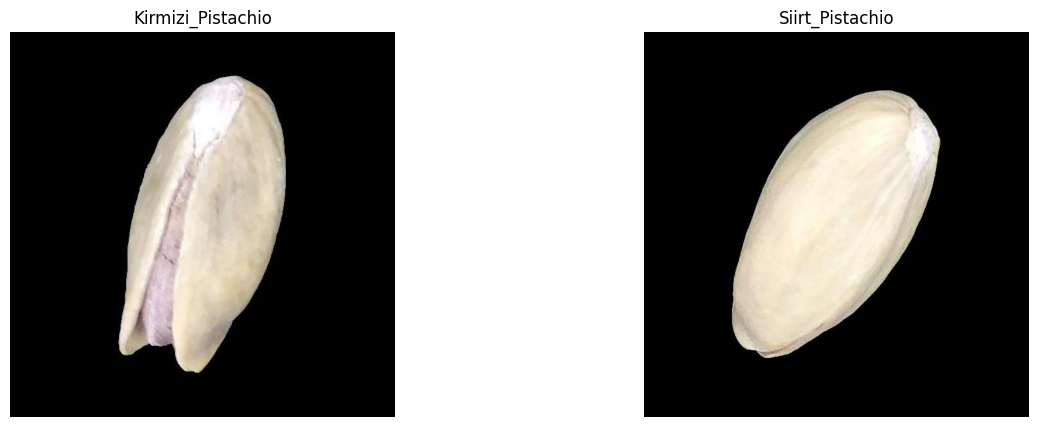

In [6]:
path_train_data = os.path.join(PATH_DATA, "train")
num_classes = len(os.listdir(path_train_data))

fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

for i, d in enumerate(os.listdir(path_train_data)):
    image_name = os.listdir(os.path.join(path_train_data, d))[0]
    image_path = os.path.join(path_train_data, d , image_name)
    image = read_image(image_path)
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_title(d)
    axes[i].axis("off")

plt.show()

Create dataframe

In [76]:
dict_train = { "Type": [], "File": [] }
for d in os.listdir(path_train_data):
    dict_train["Type"].append(d)
    dict_train["File"].append(os.listdir(os.path.join(path_train_data, d)))
df_train_full = pd.DataFrame(dict_train).head().explode("File").reset_index(drop = True)
print("Shape:", df_train_full.shape)
df_train_full.head()

Shape: (40, 2)


,Type,File
0,Kirmizi_Pistachio,kirmizi (17).jpg
1,Kirmizi_Pistachio,kirmizi (4).jpg
2,Kirmizi_Pistachio,kirmizi (2).jpg
3,Kirmizi_Pistachio,kirmizi (3).jpg
4,Kirmizi_Pistachio,kirmizi (7).jpg


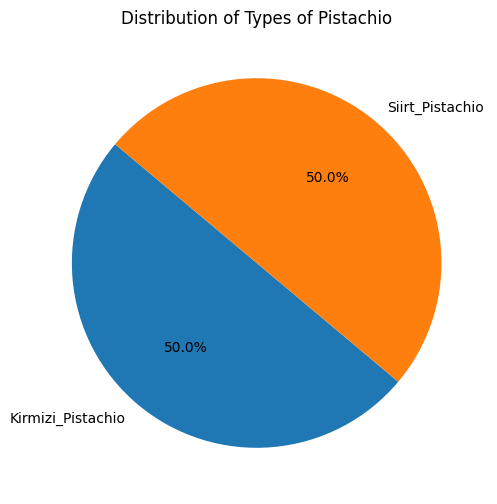

In [77]:
type_count = df_train_full["Type"].value_counts()

plt.figure(figsize = (10, 6))
plt.pie(type_count, labels = type_count.index, autopct = '%1.1f%%', startangle = 140)
plt.title("Distribution of Types of Pistachio")
plt.show()

Create dataset class

In [80]:
class PistachioDataset(torch.utils.data.Dataset):
    def __init__(self, root, df, transforms):
        self.root = root
        self.transforms = transforms

        # Get list of image paths
        self.imgs = []
        self.classes = []

        # Get list of classes
        classes = list(sorted(os.listdir(root)))

        # Get path images
        for i, d in enumerate(classes):
            # Take images from current class
            df_class = df[df["Type"] == d].reset_index(drop = True)

            for idx in range(df_class.shape[0]):
                # Add classes as numbers
                self.classes.append(i)

                # Add images
                self.imgs.append(os.path.join(root, d, df_class.loc[idx, "File"]))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.imgs[idx]

        # Get target
        target = self.classes[idx]

        # Read image as RGB Tensor (3 channels)
        img = read_image(img_path)

        # Wrap sample and targets into torchvision tv_tensors in order improve transform performance
        img = tv_tensors.Image(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

## 3. Training

Define pre-trained models

In [49]:
from torchvision.models import list_models

In [50]:
all_models = list_models()
all_models[:5]

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny']

In [51]:
from torchvision.models import resnet50, ResNet50_Weights

def get_model_resnet18(num_classes):
    model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)

    # Modify the final layer to match the number of classes
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)

    return model

In [52]:
from torchvision.models import vgg19, VGG19_Weights

def get_model_vgg19(num_classes):
    model = vgg19(weights = VGG19_Weights.IMAGENET1K_V1)

    # Modify the final layer to match the number of classes
    num_features = model.classifier[6].in_features
    model.classifier[6] = torch.nn.Linear(num_features, num_classes)

    return model

In [53]:
from torchvision.models import inception_v3, Inception_V3_Weights

def get_model_inception_v3(num_classes):
    model = inception_v3(weights = Inception_V3_Weights.IMAGENET1K_V1)

    # Modify the final layer to match the number of classes
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, num_classes)

    return model

In [54]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

def get_model_efficientnet_b0(num_classes):
    model = efficientnet_b0(weights = EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Modify the final layer to match the number of classes
    num_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_features, num_classes)

    return model

In [55]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

def get_model_mobilenet_v3_large(num_classes):
    model = mobilenet_v3_large(weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1)

    # Modify the final layer to match the number of classes
    num_features = model.classifier[3].in_features
    model.classifier[3] = torch.nn.Linear(num_features, num_classes)

    return model

In [56]:
def get_transform(train):
    transforms = []

    transforms.append(T.Resize((224, 224)))
    transforms.append(T.ToTensor())
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))

    return T.Compose(transforms)

In [57]:
def train_one_epoch(model, optimizer, criterion, data_loader, device, epoch, print_freq = 10):
    print(f"\nEpoch: {epoch}")
    print(f"Total batch iteration: {len(data_loader)}")
    model.train()

    loss = 0
    loss_accumulated = 0
    for batch, (images, targets) in enumerate(data_loader):
        # Move images and targets to the specified device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # Sum the losses for different components
        losses = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Print training information at the specified frequency
        loss = losses.item()
        loss_accumulated += loss

        if batch % print_freq == 0:
            print(f"Iteration {batch} - Loss: {loss}")

    print(f"Average training loss for total data: {loss_accumulated / len(data_loader)}")

In [58]:
def val_one_epoch(model, criterion, data_loader, device, epoch, print_freq = 10):
    print(f"\nEpoch: {epoch}")
    print(f"Total batch iteration: {len(data_loader)}")
    model.eval()

    loss = 0
    loss_accumulated = 0
    for batch, (images, targets) in enumerate(data_loader):
        # Move images and targets to the specified device (GPU or CPU)
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # Sum the losses for different components
        losses = criterion(outputs, targets)

        # Print training information at the specified frequency
        loss = losses.item()
        loss_accumulated += loss

        if batch % print_freq == 0:
            print(f"Iteration {batch} - Loss: {loss}")

    print(f"Average validation loss for total data: {loss_accumulated / len(data_loader)}")

In [81]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

df_train, df_val = train_test_split(df_train_full, test_size = 0.2, random_state = 42)

# Use our dataset and defined transformations
dataset_train = PistachioDataset(os.path.join(PATH_DATA, "train"), df_train, get_transform(train = True))
dataset_val = PistachioDataset(os.path.join(PATH_DATA, "train"), df_val, get_transform(train = False))

data_loader_train = torch.utils.data.DataLoader(
    dataset = dataset_train,
    batch_size = 8,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    dataset = dataset_val,
    batch_size = 2,
    shuffle = False
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [82]:
# Get the model
model = get_model_resnet18(num_classes)

# Move model to the right device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch)
    val_one_epoch(model, criterion, data_loader_val, device, epoch)

print("Done!")


Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.6052606105804443
Average training loss for total data: 1.2187254428863525

Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.1186877489089966
Average validation loss for total data: 0.9369511753320694

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 0.38368943333625793
Average training loss for total data: 0.45617374032735825

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 4.188025951385498
Average validation loss for total data: 1.6200739518390037
Done!


In [84]:
# Get the model
model = get_model_vgg19(num_classes)

# Move model to the right device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch)
    val_one_epoch(model, criterion, data_loader_val, device, epoch)

print("Done!")


Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.8115383386611938
Average training loss for total data: 11.216454833745956

Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.4218378067016602
Average validation loss for total data: 1.056795597076416

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 0.834267258644104
Average training loss for total data: 0.9769613891839981

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 1.0324517488479614
Average validation loss for total data: 0.896528422832489
Done!


In [85]:
# Get the model
model = get_model_inception_v3(num_classes)

# Move model to the right device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch)

print("Done!")

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 141MB/s]



Epoch: 0
Total batch iteration: 4


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [87]:
# Get the model
model = get_model_efficientnet_b0(num_classes)

# Move model to the right device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch)
    val_one_epoch(model, criterion, data_loader_val, device, epoch)

print("Done!")


Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.5792062282562256
Average training loss for total data: 1.1470520496368408

Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 0.4385251998901367
Average validation loss for total data: 0.3655695430934429

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 0.3978000581264496
Average training loss for total data: 0.32430821657180786

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 0.7653725743293762
Average validation loss for total data: 0.37525805882614804
Done!


In [88]:
# Get the model
model = get_model_mobilenet_v3_large(num_classes)

# Move model to the right device
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, criterion, data_loader_train, device, epoch)
    val_one_epoch(model, criterion, data_loader_val, device, epoch)

print("Done!")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 82.5MB/s]



Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.6970406770706177
Average training loss for total data: 1.0117394551634789

Epoch: 0
Total batch iteration: 4
Iteration 0 - Loss: 1.6082909107208252
Average validation loss for total data: 0.9190877694636583

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 0.39370810985565186
Average training loss for total data: 0.14841825235635042

Epoch: 1
Total batch iteration: 4
Iteration 0 - Loss: 0.9866306185722351
Average validation loss for total data: 0.40432214771863073
Done!
